# __DOG & CAT CLASSIFICATION by DEEP LEARNING__
Tonga 2020 - Week7 Project

__Author:__ Dao Nguyen Nhat Huynh

![alt text](https://miro.medium.com/max/2400/1*EvMbMNRHm_aOf1n4tDO1Xg.jpeg)

### __IMPORT LIBRARY__

In [0]:
import pathlib
import tensorflow as tf
import zipfile
import os
import IPython.display as display
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## __PREPARE RAW DATA__

### Download data from Kaggle

In [0]:
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"huynhdao0808","key":"5c54c0e85b1f418010be165ba094552e"}' > ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats -f test1.zip -p /catsdogs
!kaggle competitions download -c dogs-vs-cats -f train.zip -p /catsdogs

### Unzip data

In [0]:
os.chdir('/home/jupyter/data')
for file in os.listdir():
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

### Get all image paths and shuffle

In [0]:
data_root = pathlib.Path('/home/jupyter/data/train')

The date from kaggle may come with a certain order, so the data need to be shuffled to get rid of it.

In [0]:
all_image_paths = list(data_root.iterdir())
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)
image_count = len(all_image_paths)

### Show some sample pictures

Let's have a look at our cats and dogs image

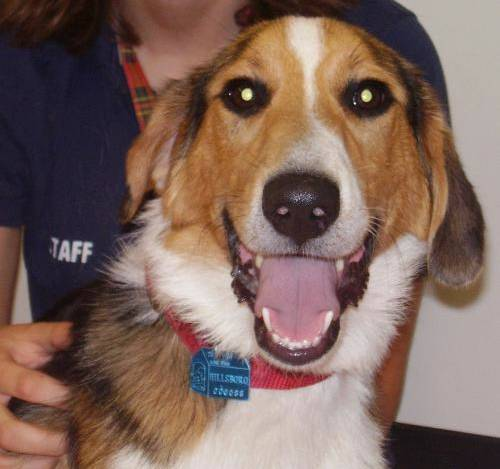

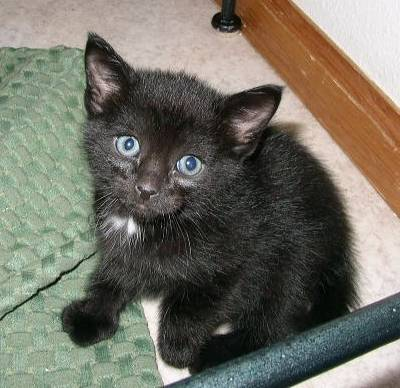

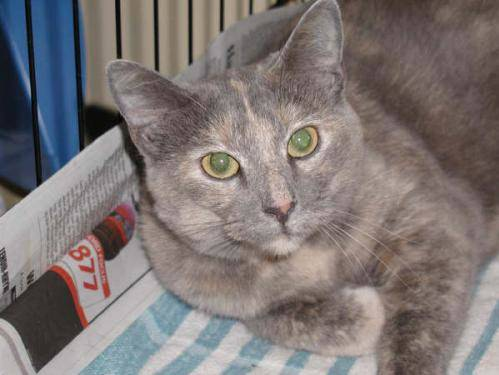

In [0]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print()

## __PREPARE TRAINING DATA__

### Prepare the label

Deep learning cannot differentiate 'cat' and 'dog', we need to change the label to 1 and 0.

In [0]:
label_to_index = {'cat':1,'dog':0}

In [0]:
all_image_labels = [label_to_index[pathlib.Path(path).name[:3]]
                    for path in all_image_paths]

In [0]:
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 1, 1, 1, 0, 1, 0, 0, 1, 1]


### Prepare data without Image Augmentation

In [0]:
# Decode jpeg and and resize image
def preprocess_image_label(path,label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224,224])
  image = image/255
  return image,label

In [0]:
# Create tf.Dataset of training data
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

In [0]:
# Map the preprocess_image function to Dataset
image_label_ds = ds.map(preprocess_image_label)

#### Split the data into trainset and test set

In [0]:
#Split the data into train set and test set
train_ds = image_label_ds.take(int(len(all_image_labels)*0.8))
test_ds = image_label_ds.skip(int(len(all_image_labels)*0.8))

#### Prepare other stuff

In [0]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Setting a shuffle buffer size as large as the dataset ensures that the data is completely shuffled.
train_ds = train_ds.shuffle(buffer_size=image_count)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)

# `prefetch` lets the dataset fetch batches in the background while the model is training.
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [0]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [0]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Setting a shuffle buffer size as large as the dataset ensures that the data is completely shuffled.
test_ds = test_ds.shuffle(buffer_size=image_count)
test_ds = test_ds.batch(BATCH_SIZE)

# `prefetch` lets the dataset fetch batches in the background while the model is training.
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [0]:
test_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

### Prepare data with Image Augmentation

* Data augmention is one of the best way to reduce the overfiting or our model. 
The `Keras` framework has an excellent utility called `ImageDataGenerator` for this purpose. 
* Below are what I will do with the images in this project:
  * Zooming the image randomly by a factor of 0.3 using the zoom_range parameter.
  * Rotating the image randomly by 50 degrees using the rotation_range parameter.
  * Translating the image randomly horizontally or vertically by a 0.2 factor of the image’s width or height using the width_shift_range and the height_shift_range parameters.
  * Applying shear-based transformations randomly using the shear_range parameter.
  Randomly flipping half of the images horizontally using the horizontal_flip parameter.
  * Leveraging the fill_mode parameter to fill in new pixels for images after we apply any of the preceding operations (especially rotation or translation). In this case, we just fill in the new pixels with their nearest surrounding pixel values.

![alt text](https://miro.medium.com/max/1400/1*OTb-WjszHutpDg4nobjG4w.png)
![alt text](https://miro.medium.com/max/1400/1*Cejzyd9kVycbuVALlvjxVw.png)

In [0]:
# Decode jpeg and and resize image
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224,224])
  return image.numpy()

In [0]:
train_imgs_paths = all_image_paths[:int(2500*0.8)]
train_labels = np.array(all_image_labels[:int(2500*0.8)]).reshape(-1,1)

In [0]:
test_imgs_paths = all_image_paths[int(2500*0.8):2500]
test_labels = np.array(all_image_labels[int(2500*0.8):2500]).reshape(-1,1)

In [0]:
# Map the preprocess_image function to Dataset
image_ds_train = np.array([preprocess_image(path) for path in train_imgs_paths])
image_ds_test =np.array([preprocess_image(path) for path in test_imgs_paths])

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(image_ds_train, train_labels, batch_size=40)
test_generator = test_datagen.flow(image_ds_test, test_labels, batch_size=20)

## __TRAINING__

In [0]:
# Visualize model history
def plot_history(history, key='loss'):
    plt.figure(figsize=(12,8))

    val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=key.title() +' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=key.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

Training process:
* Firstly, creating the baseline model with different pretrained model in `Keras`
* Secondly, fine tuning

### __Pretrained model selection__

There are a lof of models in Keras application that I only choose 3 model for comparison in this case:
* Xception: Light but still have good performance
* MobileNetV2: Super light
* NASNetLarge: Supper heavy but have the best perfomance

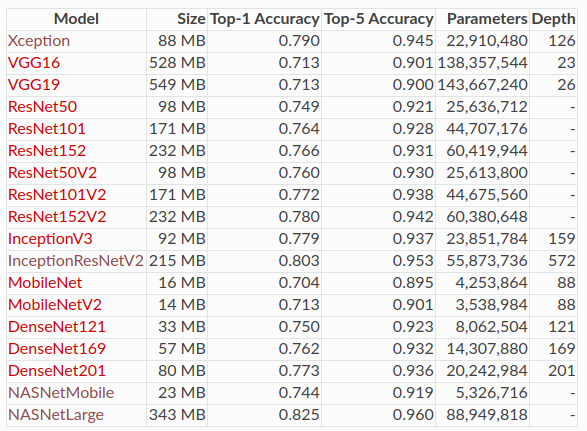

### MobileNet Model

In [0]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
mobile_net.trainable=False

In [0]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [0]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               163968    
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 129       
Total params: 2,422,081
Trainable params: 164,097
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
history = model.fit(train_generator, epochs=50, validation_data = test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 25 steps
Epoch 1/5
50/50 [==============================] - 23s 465ms/step - loss: 0.3141 - accuracy: 0.8575 - val_loss: 0.1116 - val_accuracy: 0.9680
Epoch 2/5
50/50 [==============================] - 21s 411ms/step - loss: 0.1850 - accuracy: 0.9235 - val_loss: 0.1261 - val_accuracy: 0.9620
Epoch 3/5
50/50 [==============================] - 20s 408ms/step - loss: 0.1610 - accuracy: 0.9375 - val_loss: 0.2280 - val_accuracy: 0.9260
Epoch 4/5
50/50 [==============================] - 20s 405ms/step - loss: 0.1704 - accuracy: 0.9300 - val_loss: 0.1517 - val_accuracy: 0.9540
Epoch 5/5
50/50 [==============================] - 20s 406ms/step - loss: 0.1505 - accuracy: 0.9395 - val_loss: 0.1725 - val_accuracy: 0.9520


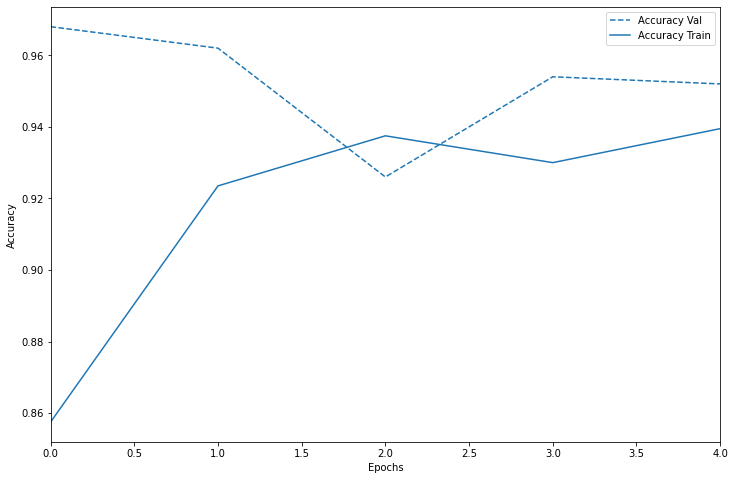

In [0]:
plot_history(history, key='accuracy')

### Xception model

In [0]:
Xception = tf.keras.applications.Xception(input_shape=(224, 224, 3), include_top=False)
Xception.trainable=False
model = tf.keras.Sequential([
    Xception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 
                          kernel_initializer='he_uniform',
                          activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=["accuracy"])


history = model.fit(train_generator, epochs=50, 
                    validation_data = test_generator,
                    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 25 steps
Epoch 1/50
50/50 [==============================] - 24s 470ms/step - loss: 1.0620 - accuracy: 0.8415 - val_loss: 0.2854 - val_accuracy: 0.9620
Epoch 2/50
50/50 [==============================] - 21s 423ms/step - loss: 0.3488 - accuracy: 0.9005 - val_loss: 0.0717 - val_accuracy: 0.9780
Epoch 3/50
50/50 [==============================] - 21s 427ms/step - loss: 0.1845 - accuracy: 0.9260 - val_loss: 0.0297 - val_accuracy: 0.9920
Epoch 4/50
50/50 [==============================] - 21s 418ms/step - loss: 0.1885 - accuracy: 0.9240 - val_loss: 0.1836 - val_accuracy: 0.9460
Epoch 5/50
50/50 [==============================] - 21s 422ms/step - loss: 0.1707 - accuracy: 0.9335 - val_loss: 0.1028 - val_accuracy: 0.9720
Epoch 6/50
50/50 [==============================] - 21s 422ms/step - loss: 0.1813 - accuracy: 0.9375 - val_loss: 0.0767 - val_accuracy: 0.9860
Epoch 7/50
50/50 [==============================] 

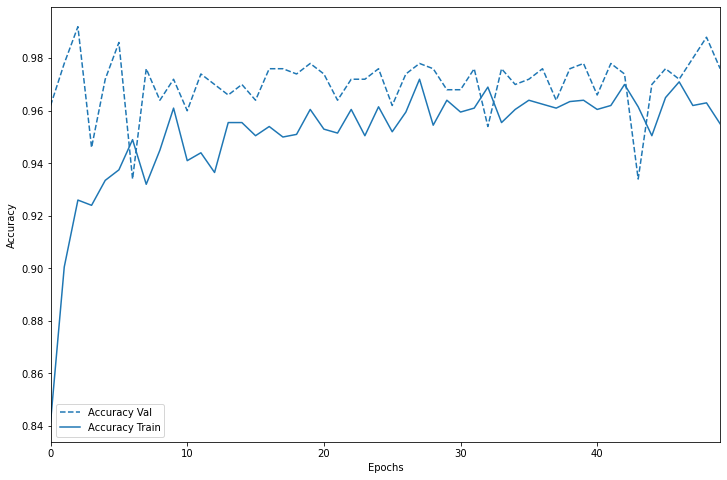

In [0]:
plot_history(history, key='accuracy')

In [0]:
# Save model
model.save('catdog_classifier_Xception.h5')

### NASNetLarge Model

In [0]:
NasNetLarge=tf.keras.applications.nasnet.NASNetLarge(input_shape=(224, 224, 3), include_top=False, weights=None)
NasNetLarge.trainable=False

In [0]:
model = tf.keras.Sequential([
    NasNetLarge,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 
                          kernel_initializer='he_uniform',
                          activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [0]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
history = model.fit(train_ds, epochs=50, 
                    validation_data = test_ds,
                    steps_per_epoch=steps_per_epoch,
                    )

In [0]:
tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()

In [0]:
plot_history(history, key='accuracy')

### Result


Pretrained model are listed by there accuraccy:
* Xception
* MobileNetV2
* NASNetLarge

Xception will be chosen

### __Fine Tunning__

### Add more layer, L2 regularizer and Drop out

In [0]:
Xception = tf.keras.applications.Xception(input_shape=(224, 224, 3), include_top=False)

In [0]:
#@title
Xception.trainable=False
Xception_model = tf.keras.Sequential([
    Xception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, 
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          kernel_initializer='he_uniform',
                          activation='relu'),
    tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, 
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          kernel_initializer='he_uniform',
                          activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6),
              loss='binary_crossentropy',
              metrics=["accuracy"])

history = model.fit(train_generator, epochs=50, 
                    validation_data = test_generator,
                    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 25 steps
Epoch 1/50
50/50 [==============================] - 23s 465ms/step - loss: 0.7994 - accuracy: 0.6820 - val_loss: 0.3992 - val_accuracy: 0.9560
Epoch 2/50
50/50 [==============================] - 20s 406ms/step - loss: 0.6142 - accuracy: 0.8495 - val_loss: 0.3046 - val_accuracy: 0.9740
Epoch 3/50
50/50 [==============================] - 20s 407ms/step - loss: 0.5176 - accuracy: 0.8905 - val_loss: 0.2921 - val_accuracy: 0.9740
Epoch 4/50
50/50 [==============================] - 20s 407ms/step - loss: 0.4778 - accuracy: 0.9000 - val_loss: 0.2944 - val_accuracy: 0.9660
Epoch 5/50
50/50 [==============================] - 20s 408ms/step - loss: 0.4608 - accuracy: 0.9045 - val_loss: 0.2768 - val_accuracy: 0.9740
Epoch 6/50
50/50 [==============================] - 21s 412ms/step - loss: 0.4126 - accuracy: 0.9235 - val_loss: 0.2788 - val_accuracy: 0.9760
Epoch 7/50
50/50 [==============================] 

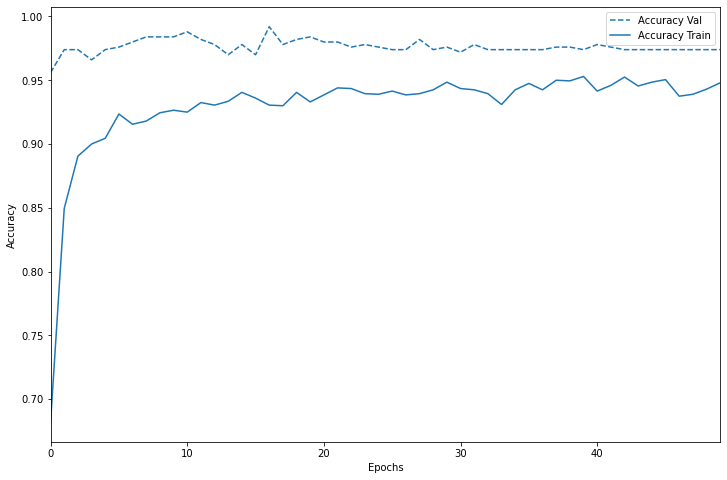

In [0]:
plot_history(history, key='accuracy')

The result show my model is a little bit under fitting.
Next step, I will try to unfreeze some layers in Xception

### Unfreeze some layers in Xception

In [0]:
layers_name = [layer.name for layer in Xception.layers][-8:]

In [0]:
Xception.trainable= True

set_trainable = False
for layer in Xception.layers:
    if layer.name in layers_name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
layers = [(layer, layer.name, layer.trainable) for layer in Xception.layers]
data = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

In [0]:
data.tail(20)

,Layer Type,Layer Name,Layer Trainable
112,<tensorflow.python.keras.layers.core.Activatio...,block12_sepconv3_act,False
113,<tensorflow.python.keras.layers.convolutional....,block12_sepconv3,False
114,<tensorflow.python.keras.layers.normalization....,block12_sepconv3_bn,False
115,<tensorflow.python.keras.layers.merge.Add obje...,add_10,False
116,<tensorflow.python.keras.layers.core.Activatio...,block13_sepconv1_act,False
117,<tensorflow.python.keras.layers.convolutional....,block13_sepconv1,False
118,<tensorflow.python.keras.layers.normalization....,block13_sepconv1_bn,False
119,<tensorflow.python.keras.layers.core.Activatio...,block13_sepconv2_act,False
120,<tensorflow.python.keras.layers.convolutional....,block13_sepconv2,False
121,<tensorflow.python.keras.layers.normalization....,block13_sepconv2_bn,False


### Baseline model with unfrezzed pretrained model

In [0]:
Xception_model = tf.keras.Sequential([
    Xception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 
                          kernel_initializer='he_uniform',
                          activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

Xception_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=["accuracy"])

Xception_history = Xception_model.fit(train_generator, epochs=50, 
                    validation_data = test_generator,
                    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 25 steps
Epoch 1/50
50/50 [==============================] - 21s 416ms/step - loss: 0.0841 - accuracy: 0.9695 - val_loss: 0.2104 - val_accuracy: 0.9520
Epoch 2/50
50/50 [==============================] - 21s 414ms/step - loss: 0.0751 - accuracy: 0.9670 - val_loss: 0.4040 - val_accuracy: 0.9140
Epoch 3/50
50/50 [==============================] - 21s 414ms/step - loss: 0.0575 - accuracy: 0.9805 - val_loss: 0.2604 - val_accuracy: 0.9500
Epoch 4/50
50/50 [==============================] - 21s 413ms/step - loss: 0.0710 - accuracy: 0.9700 - val_loss: 0.3840 - val_accuracy: 0.9260
Epoch 5/50
50/50 [==============================] - 21s 412ms/step - loss: 0.0702 - accuracy: 0.9730 - val_loss: 0.2660 - val_accuracy: 0.9540
Epoch 6/50
50/50 [==============================] - 21s 414ms/step - loss: 0.0778 - accuracy: 0.9685 - val_loss: 0.2287 - val_accuracy: 0.9480
Epoch 7/50
50/50 [==============================] 

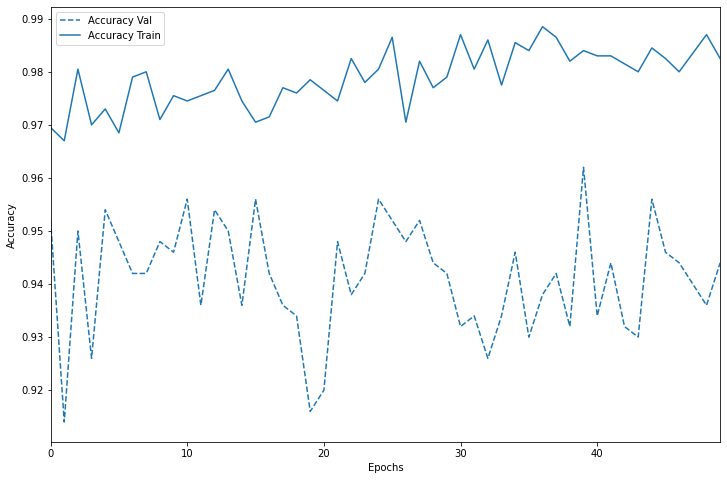

In [0]:
plot_history(Xception_history, key='accuracy')

The model become overftiting, need to use L2 regularizer and dropout

### Baseline model with unfrezzed Xception, L2 regularizers and drop out

In [0]:
Xception_model = tf.keras.Sequential([
    Xception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, 
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          kernel_initializer='he_uniform',
                          activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

Xception_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=["accuracy"])

Xception_history = Xception_model.fit(train_generator, epochs=50, 
                    validation_data = test_generator,
                    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 25 steps
Epoch 1/50
50/50 [==============================] - 26s 521ms/step - loss: 0.6811 - accuracy: 0.8735 - val_loss: 0.3546 - val_accuracy: 0.9680
Epoch 2/50
50/50 [==============================] - 22s 436ms/step - loss: 0.1953 - accuracy: 0.9370 - val_loss: 0.1703 - val_accuracy: 0.9860
Epoch 3/50
50/50 [==============================] - 22s 433ms/step - loss: 0.1711 - accuracy: 0.9525 - val_loss: 0.2452 - val_accuracy: 0.9740
Epoch 4/50
50/50 [==============================] - 22s 437ms/step - loss: 0.1670 - accuracy: 0.9570 - val_loss: 0.3163 - val_accuracy: 0.9700
Epoch 5/50
50/50 [==============================] - 22s 435ms/step - loss: 0.1330 - accuracy: 0.9660 - val_loss: 0.1977 - val_accuracy: 0.9720
Epoch 6/50
50/50 [==============================] - 22s 435ms/step - loss: 0.1223 - accuracy: 0.9720 - val_loss: 0.3379 - val_accuracy: 0.9660
Epoch 7/50
50/50 [==============================] 

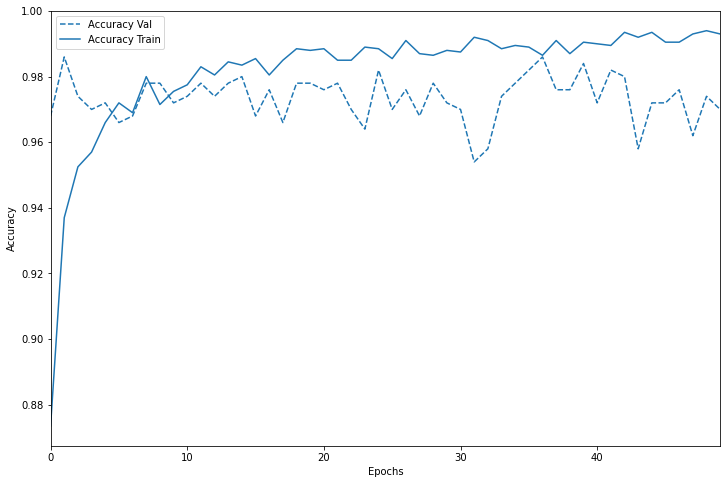

In [0]:
plot_history(Xception_history, key='accuracy')

The overfitting improved, but the performance is still not good.

### More layer, L2 regularizer, drop out and unfreezed Xception

In [0]:
Xception_model = tf.keras.Sequential([
    Xception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, 
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          kernel_initializer='he_uniform',
                          activation='relu'),
    tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, 
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                          kernel_initializer='he_uniform',
                          activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation = 'sigmoid')])

Xception_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=["accuracy"])

Xception_history = Xception_model.fit(train_generator, epochs=50, 
                    validation_data = test_generator,
                    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 25 steps
Epoch 1/50
50/50 [==============================] - 24s 473ms/step - loss: 1.1983 - accuracy: 0.8735 - val_loss: 0.4367 - val_accuracy: 0.9880
Epoch 2/50
50/50 [==============================] - 20s 391ms/step - loss: 0.4781 - accuracy: 0.9390 - val_loss: 0.3821 - val_accuracy: 0.9880
Epoch 3/50
50/50 [==============================] - 20s 396ms/step - loss: 0.4962 - accuracy: 0.9390 - val_loss: 0.3940 - val_accuracy: 0.9880
Epoch 4/50
50/50 [==============================] - 20s 390ms/step - loss: 0.4402 - accuracy: 0.9450 - val_loss: 0.3084 - val_accuracy: 0.9880
Epoch 5/50
50/50 [==============================] - 20s 392ms/step - loss: 0.3666 - accuracy: 0.9550 - val_loss: 0.2681 - val_accuracy: 0.9900
Epoch 6/50
50/50 [==============================] - 19s 390ms/step - loss: 0.4010 - accuracy: 0.9555 - val_loss: 0.2956 - val_accuracy: 0.9900
Epoch 7/50
50/50 [==============================] 

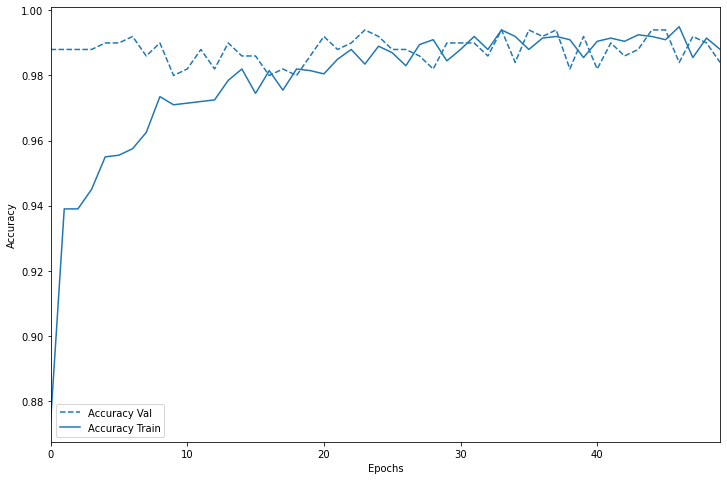

In [0]:
plot_history(Xception_history, key='accuracy')

The model look nice. I decide to finish now.

In [0]:
# Save model
Xception_model.save('catdog_classifier_Xception.h5')